In [72]:
import tensorflow as tf


In [73]:
import numpy as np
tensor_1d = np.array([1.3, 1, 4.0, 23.99])
print(tensor_1d) 

[ 1.3   1.    4.   23.99]


In [74]:
print(tf.__version__)
print(tf.test.gpu_device_name())

# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

2.3.0



# Building An Inception Module
> This notebook contains the structure and the training/validation results from our 3rd model. 

>> While the inception module was successfully constructed, the loss/accuracy was not as good as the 2nd model architecture we designed (see CNN_for_food_classification.ipynb).

In [75]:
get_data_extract()


Dataset already exists


In [76]:
!ls food-101/

import os
# for filename in os.listdir('food-101/images')[:10]:
#     print(filename)
for filename in os.listdir('food-101/images')[60:70]:
    print(filename)

images		       meta	   test   test_mini  train_mini
license_agreement.txt  README.txt  test5  train
hot_and_sour_soup
spaghetti_carbonara
chocolate_cake
tacos
fish_and_chips
oysters
hot_dog
foie_gras
macarons
eggs_benedict


In [77]:
import numpy as np
from collections import defaultdict
import collections
import os

In [78]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [79]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [80]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [81]:
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test5')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [82]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [83]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [84]:
# Helper method to create train_mini and test_mini data samples
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [85]:
# picking 4 food items and generating separate data folders for the same
food_list = ['ramen','guacamole','donuts','churros']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'


In [86]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into ramen
Copying images into guacamole
Copying images into donuts
Copying images into churros


In [87]:
print("Total number of samples in train folder")

!find food-101/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
3000


In [88]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into ramen
Copying images into guacamole
Copying images into donuts
Copying images into churros


In [89]:
print("Total number of samples in test folder")
!find food-101/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
1000


In [90]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPool2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np


import warnings
warnings.filterwarnings('ignore')




from keras.utils import np_utils


K.clear_session()

n_classes = 4
img_width, img_height = 299, 299
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
nb_train_samples = 3000 #75750
nb_validation_samples = 1000 #25250
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator() #(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical')





Found 3000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [92]:
from keras.layers import Conv2D, MaxPooling2D

from keras.layers import Input
input_img = Input(shape = (64, 64, 3))

tower_1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(128, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(128, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(128, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(128, (1,1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

from keras.layers import Flatten, Dense
output = Flatten()(output)
out    = Dense(4, activation='softmax')(output)

from keras.models import Model
incept = Model(inputs = input_img, outputs = out)


from keras.optimizers import SGD
epochs = 5
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
incept.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
incept.fit(train_generator, validation_data=validation_generator, epochs=epochs, batch_size=4)

from keras.models import model_from_json
import os
model_json = incept.to_json()
with open("incept.json", "w") as json_file:
    json_file.write(model_json)
incept.save_weights(os.path.join(os.getcwd(), 'model.h5'))

scores = incept.evaluate(train_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5
94/94 [==============================] - 944s 10s/step - loss: 1.6736 - accuracy: 0.3543 - val_loss: 101.3515 - val_accuracy: 0.3330
Epoch 2/5
94/94 [==============================] - 943s 10s/step - loss: 1.2431 - accuracy: 0.4327 - val_loss: 165.9538 - val_accuracy: 0.3580
Epoch 3/5
94/94 [==============================] - 942s 10s/step - loss: 1.1587 - accuracy: 0.4860 - val_loss: 320.6444 - val_accuracy: 0.2960
Epoch 4/5
94/94 [==============================] - 943s 10s/step - loss: 1.1080 - accuracy: 0.5190 - val_loss: 309.1266 - val_accuracy: 0.3210
Epoch 5/5
94/94 [==============================] - 950s 10s/step - loss: 1.1109 - accuracy: 0.5153 - val_loss: 85.3634 - val_accuracy: 0.4480
Accuracy: 53.47%


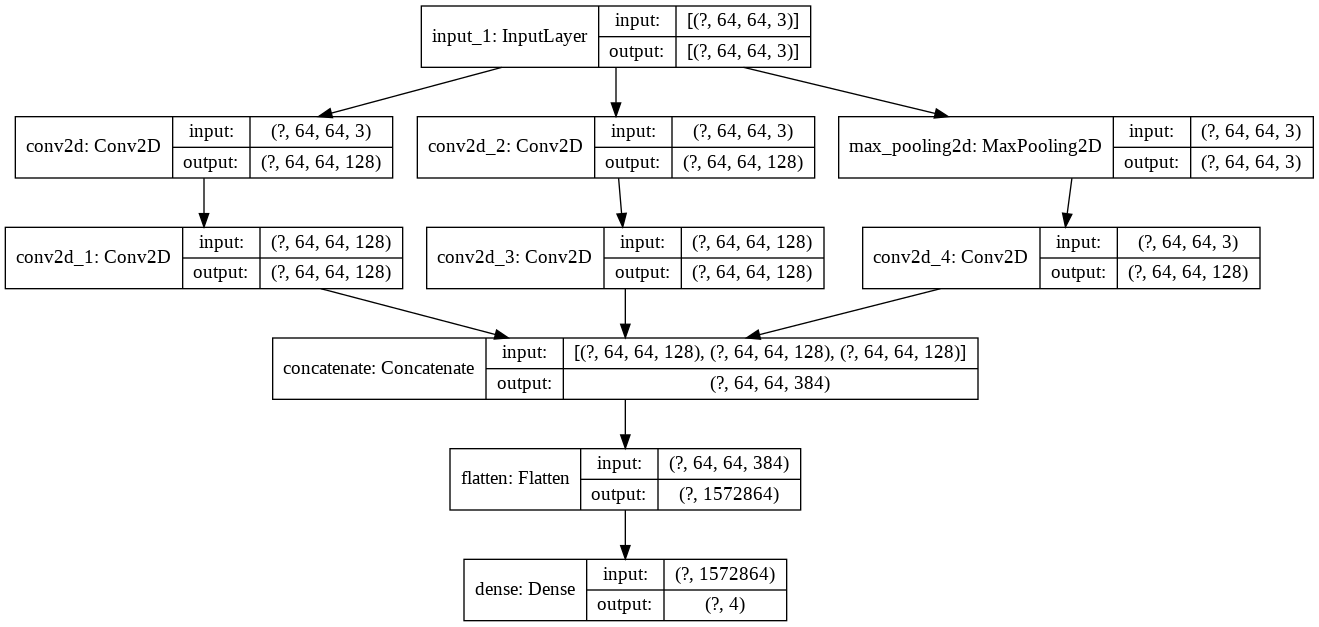

In [94]:
tf.keras.utils.plot_model(incept, to_file='incept.png', show_shapes=True, show_layer_names=True)